## Packages Used

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sb

## Dataset to get the year from 2014-2020

In [3]:
new_df = pd.read_csv("New Dataset.csv")

# Renaming the columns as our need
new_df = new_df.rename(columns={'Event':'Disaster','Date (YMD)':'Date','&quot;Code Province&quot;':'Code Region','&quot;Code District&quot;':'Code District',
                                '&quot;Code Division&quot;':'Code Commune','&quot;Division&quot;':'Location'})

comb_needed = ['Disaster','Code Region','Code District','Code Commune','Location','Date']

new_df = new_df[comb_needed]

/var/folders/_x/05s1mgk171vd_snfhp0tsfyr0000gn/T/ipykernel_33629/2435295531.py:1: DtypeWarning: Columns (14,15,16,21) have mixed types. Specify dtype option on import or set low_memory=False.
  new_df = pd.read_csv("New Dataset.csv")


## Dataset to get the year up to 2014

In [4]:
old_df = pd.read_csv("Original Dataset.csv")

# Renaming the columns as our need
old_df = old_df.rename(columns={'Event':'Disaster','Date (YMD)':'Date'})
needed_columns = ['Disaster','Code Region','Code District','Code Commune','Location','Date']

old_df=old_df[needed_columns]


## Combine both datasets and remove duplicates

In [5]:
combined_df = pd.concat([old_df,new_df],ignore_index=True)
combined_df = combined_df.drop_duplicates()
combined_df.to_csv('Combined Dataset.csv',index=False)

## Select only the needed disasters

In [6]:
df = combined_df

disasters = ['FLOOD','CYCLONE & FLOOD','FLASH FLOOD','URBAN FLOOD','COASTLINE','LANDSLIDE','LAND SUBSIDENCE',
            'CYCLONE','Collapse of Mine','COASTLINE','GALE','HAILSTORM','STORM','STRONG WIND','TIDAL WAVE','TORNADO',
            'ROCK FALL','EARTH SLIP','HEAVY RAINS','Subsidence','Collapse of Gabage Fill']
df = df[df["Disaster"].isin(disasters)]

## Select only the years after 2000. 

In [7]:
df['Date'] = pd.to_datetime(df['Date'],errors='coerce')

df = df[(df['Date'].dt.year >= 2000) & (df['Date'].dt.year <=2021)].copy()

/var/folders/_x/05s1mgk171vd_snfhp0tsfyr0000gn/T/ipykernel_33629/1660549776.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'],errors='coerce')


/var/folders/_x/05s1mgk171vd_snfhp0tsfyr0000gn/T/ipykernel_33629/1660549776.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'],errors='coerce')


## Mapping the Districts to the District Codes

In [8]:
districts = {
    'lka001001':'Colombo',
    'lka001002':'Gampaha',
    'lka001003':'Kaluthara',
    'lka002001':'Kandy',
    'lka002002':'Matale',
    'lka002003':'Nuwara Eliya',
    'lka003001':'Galle',
    'lka003002':'Matara',
    'lka003003':'Hambantota',
    'lka004001':'Jaffna',
    'lka004002':'Mannar',
    'lka004003':'Vavuniya',
    'lka004004':'Mullaitivu',
    'lka004005':'Kilinochchi',
    'lka005001':'Batticaloa',
    'lka005002':'Ampara',
    'lka005003':'Trincomalee',
    'lka006001':'Kurunegala',
    'lka006002':'Puttalam',
    'lka007001':'Anuradhapura',
    'lka007002':'Polannaruwa',
    'lka008001':'Badulla',
    'lka008002':'Monaragala',
    'lka009001':'Ratnapura',
    'lka009002':'Kegalle'
}

df['District'] = df['Code District'].map(districts)
df['Code District'] = df['Code District'].str[3:]
df['Code Commune'] = df['Code Commune'].str[3:]
df['Code Region'] = df['Code Region'].str[3:]

col_order = ['Disaster', 'Code Region', 'Code District', 'Code Commune', 'Location',
            'District','Date']

df = df[col_order]

## Split if there are more than one location

In [9]:
df =df.dropna(subset=['District'])
def split_locations(row):
    if pd.isna(row['Location']):
        return [row]
    
    locations = [loc.strip() for loc in row['Location'].split(',') if loc.strip()]
    if not locations:
        return [row]
    rows = []
    for loc in locations:
        new_row = row.copy()
        new_row['Location'] = loc
        rows.append(new_row)
    return rows

new_rows = []
for index, row in df.iterrows():
    new_rows.extend(split_locations(row))

new_df = pd.DataFrame(new_rows)
df = new_df

## Clean Location Values

In [10]:
for index, row in df.iterrows():
        if pd.isna(row['Location']):
                continue
        location = row['Location']
        location = location.replace("GN",'')
        # Keep spaces and 'GN' within brackets, and alphabetic characters
        location = ''.join([char if char.isalpha() or char.isspace()  else '' for char in location]).strip()
        df.at[index,'Location'] = location
        
df.replace('', np.nan, inplace=True)
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

## Fill Location based on Code Commune

In [11]:
def fill_location_nan(row):
    if pd.isna(row['Location']):
        code_commune = row['Code Commune']
        matching_row = df[(df['Code Commune'] == code_commune) & (~pd.isna(df['Location']))]
        if not matching_row.empty:
            filled_value = matching_row['Location'].iloc[0]
            return filled_value
    return row['Location']
df['Location'] = df.apply(fill_location_nan, axis=1)

## Fill Code Commune based on Location

In [12]:
def fill_code_commune_nan(row):
    if pd.isna(row['Code Commune']):
        location = row['Location']
        matching_row = df[(df['Location'] == location) & (~pd.isna(df['Code Commune']))]
        if not matching_row.empty:
            filled_value = matching_row['Code Commune'].iloc[0]
            return filled_value
    return row['Code Commune']
df['Code Commune'] = df.apply(fill_code_commune_nan, axis=1)

## Fill where both of them are nan

In [13]:
def fill_code_commune_location_nan(row):
    if pd.isna(row['Code Commune']) and pd.isna(row['Location']):
        code_district = row['Code District']
        district_data = df[df['Code District'] == code_district]

        if not district_data.empty:
            mode_code_commune = district_data['Code Commune'].mode().iloc[0]
            mode_location = district_data['Location'].mode().iloc[0]
            return mode_code_commune, mode_location

    return row['Code Commune'], row['Location']

df[['Code Commune', 'Location']] = df.apply(fill_code_commune_location_nan, axis=1, result_type='expand')


## Fill Code Commune with new sequence

In [14]:
df['Code Commune'] = pd.to_numeric(df['Code Commune'], errors='coerce')
max_code_commune_by_district = df.groupby('Code District')['Code Commune'].max()

def fill_code_commune_nan(row):
    if pd.isna(row['Code Commune']):
        district_code = row['Code District']
        max_code_commune = max_code_commune_by_district.get(district_code, 0)
        new_code_commune = max_code_commune + 1
        return new_code_commune
    return row['Code Commune']

df['Code Commune'] = df.apply(fill_code_commune_nan, axis=1)
df['Location'] = df['Location'].str.replace(r'\s+', ' ', regex=True).str.title()
df['District'] = df['District'].str.title()
df['Code Commune'] = df['Code Commune'].astype(int)

## Preprocess Weather Dataframes

In [15]:
weather_df = pd.read_csv("Rf data.csv").dropna()
weather_df = weather_df.rename(columns={'station_name':'District','yyyy':'Year'})
columns = ['District','Year','1','2','3','4','5','6','7','8','9','10','11','12']
weather_df = weather_df[columns]
weather_df['District'] = weather_df['District'].str.capitalize()
weather_df.loc[weather_df['District']=='Katugastota','District']= 'Kandy'
weather_df.loc[weather_df['District']=='Pottuvil','District']= 'Ampara'
weather_df.loc[weather_df['District']=='Nuwara eliya','District']= 'Nuwara Eliya'
weather_df['Year']=weather_df['Year'].astype(int)

## Insert New Columns

In [16]:
rainfall_melted = pd.melt(weather_df, id_vars=[ 'District', 'Year'], var_name='Month', value_name='Rainfall(mm)')

df['Rainfall(mm)'] = 0
df['Wind Speed(mph)'] = 0

## Insert weather by comparing date and location

In [17]:
rainfall_melted['Month'] = rainfall_melted['Month'].astype(int)
for idx, row in df.iterrows():
    
    matching_rows = rainfall_melted[(rainfall_melted['Year'] == row['Year']) &
                                    (rainfall_melted['Month'] == row['Month']) &
                                    (rainfall_melted['District'] == row['District'])]
    
    if not matching_rows.empty:
        matching_index = matching_rows.index[0]
        rainfall_value = matching_rows.at[matching_index, 'Rainfall(mm)']
        df.at[idx, 'Rainfall(mm)'] = rainfall_value


/var/folders/_x/05s1mgk171vd_snfhp0tsfyr0000gn/T/ipykernel_33629/3219423715.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '72.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'Rainfall(mm)'] = rainfall_value


## Read the weather data and transpose it 

In [18]:
avg_wind = pd.read_csv('Wind_Average.csv')
avg_rainfall = pd.read_csv('Rainfall_Average.csv')

avg_rainfall_melted = pd.melt(avg_rainfall, id_vars=[ 'District'], var_name='Month', value_name='Rainfall(mm)')
wind_melted = pd.melt(avg_wind, id_vars=[ 'District'], var_name='Month', value_name='Wind Speed(mph)')

## Insert Average Rainfall and Wind Speed

In [19]:
avg_rainfall_melted = avg_rainfall_melted.reset_index(drop=True)

for idx, row in df.iterrows():
    matching_row_rf = avg_rainfall_melted[(avg_rainfall_melted['Month'].astype(int) == row['Month']) &
                                    (avg_rainfall_melted['District'] == row['District'])]
    matching_row_ws = wind_melted[(wind_melted['Month'].astype(int) == row['Month']) &
                                    (wind_melted['District'] == row['District'])]
    
    if not matching_row_rf.empty and row['Rainfall(mm)']==0.0:
        new_rainfall_value = matching_row_rf.iloc[0]['Rainfall(mm)']
        df.at[idx, 'Rainfall(mm)'] = new_rainfall_value
    if not matching_row_ws.empty:
        matching_index = matching_row_ws.index[0]
        wind_value = matching_row_ws.at[matching_index, 'Wind Speed(mph)']
        df.at[idx, 'Wind Speed(mph)'] = wind_value

df['Code District'] = df['Code District'].astype(int)
df.to_csv('Preprocessed.csv',index=False)

/var/folders/_x/05s1mgk171vd_snfhp0tsfyr0000gn/T/ipykernel_33629/3241303590.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.7' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'Wind Speed(mph)'] = wind_value


## Separate the disasters into 3 different files

In [20]:
df = pd.read_csv('Preprocessed.csv')

Flood=['FLOOD','CYCLONE & FLOOD','FLASH FLOOD','URBAN FLOOD','COASTLINE','HEAVY RAINS']
Landslide = ['LANDSLIDE','LAND SUBSIDENCE','ROCK FALL','EARTH SLIP','Collapse of Gabage Fill','Collapse of Mine','Subsidence']
Cyclone = ['CYCLONE','COASTLINE','CYCLONE & FLOOD','GALE','HAILSTORM','STORM','STRONG WIND','TIDAL WAVE','TORNADO']

# Categorize disasters
floods = df[df['Disaster'].str.upper().isin(Flood)].reset_index(drop=True).copy()
floods.dropna(subset=['District'], inplace=True)
floods['Code Commune'] = floods['Code Commune'].astype(int)
floods['Disaster'] = 'Flood'
floods['Flood'] = 1

landslides = df[df['Disaster'].str.upper().isin(Landslide)].reset_index(drop=True).copy()
landslides.dropna(subset=['District'], inplace=True)
landslides['Code Commune'] = landslides['Code Commune'].astype(int)
landslides['Disaster'] = 'Landslide'
landslides['Landslide'] = 1

cyclones = df[df['Disaster'].str.upper().isin(Cyclone)].reset_index(drop=True).copy()
cyclones.dropna(subset=['District'], inplace=True)
cyclones['Code Commune'] = cyclones['Code Commune'].astype(int)
cyclones['Disaster'] = 'Cyclone'
cyclones['Cyclone'] = 1


## Plot of Flood vs Month

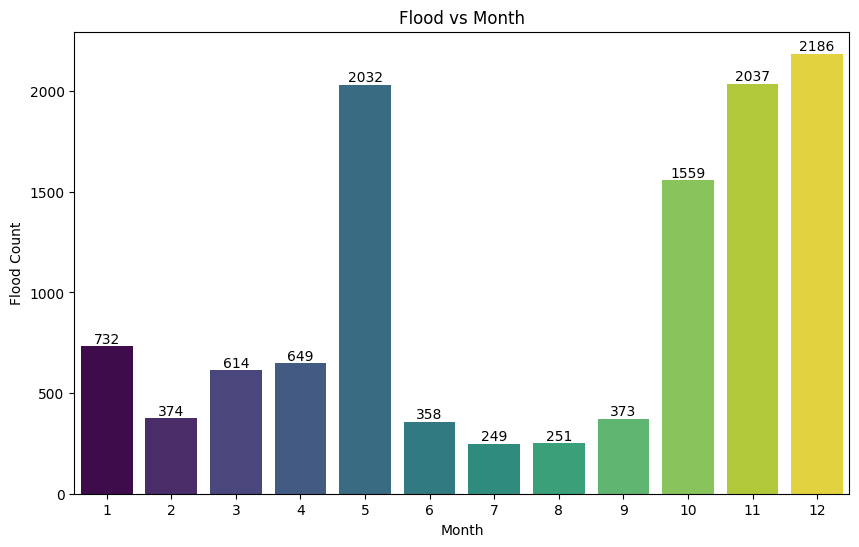

In [21]:
flood_counts = floods['Month'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
barplot = sb.barplot(x=flood_counts.index, y=flood_counts.values, hue=flood_counts.index, palette='viridis', legend=False)

# Annotate each bar with its height using ax.text method
for bar, count in zip(barplot.patches, flood_counts.values):
    barplot.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f'{int(count)}',
                ha='center', va='bottom', color='black', fontsize=10)

plt.title('Flood vs Month')
plt.xlabel('Month')
plt.ylabel('Flood Count')
plt.show()


## Plot of Landslide vs Month

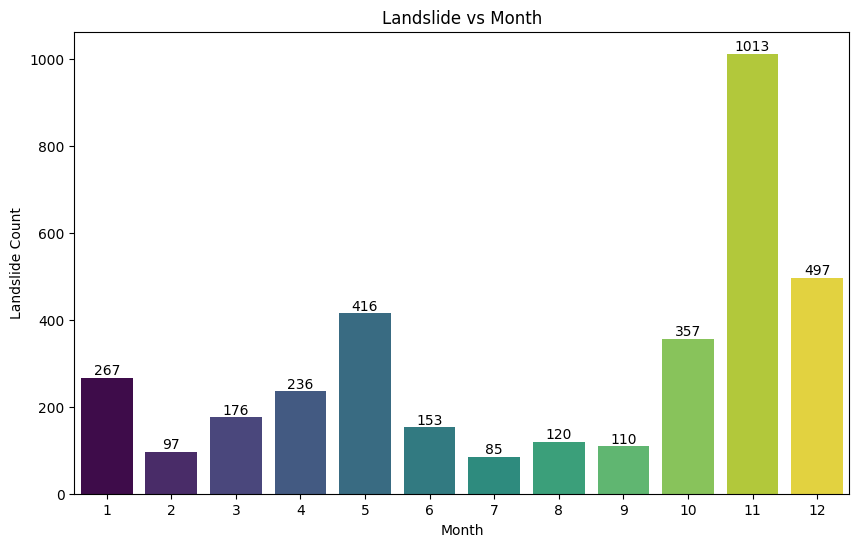

In [22]:
landslide_counts = landslides['Month'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
barplot = sb.barplot(x=landslide_counts.index, y=landslide_counts.values, hue=landslide_counts.index, palette='viridis', legend=False)

# Annotate each bar with its height using ax.text method
for bar, count in zip(barplot.patches, landslide_counts.values):
    barplot.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f'{int(count)}',
                ha='center', va='bottom', color='black', fontsize=10)

plt.title('Landslide vs Month')
plt.xlabel('Month')
plt.ylabel('Landslide Count')
plt.show()

## Plot Cyclone vs Month

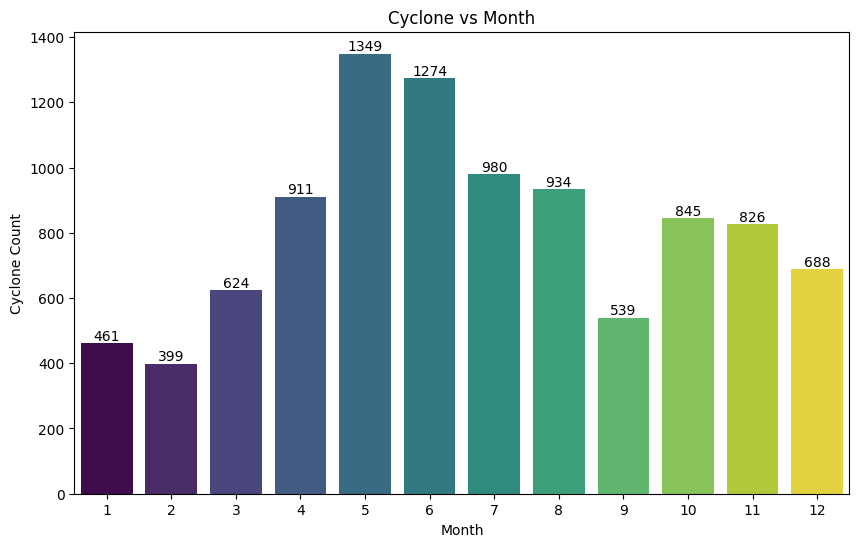

In [23]:
cyclone_counts = cyclones['Month'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
barplot = sb.barplot(x=cyclone_counts.index, y=cyclone_counts.values, hue=cyclone_counts.index, palette='viridis', legend=False)

# Annotate each bar with its height using ax.text method
for bar, count in zip(barplot.patches, cyclone_counts.values):
    barplot.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f'{int(count)}',
                ha='center', va='bottom', color='black', fontsize=10)

plt.title('Cyclone vs Month')
plt.xlabel('Month')
plt.ylabel('Cyclone Count')
plt.show()

## Function to get the random dates and xheck duplicate dates

In [24]:
def generate_random_date(year, month):
    start_date = datetime(year, month, 1)
    end_date = start_date + timedelta(days=30)
    random_date = start_date + timedelta(days=np.random.randint((end_date - start_date).days))
    return random_date

def is_duplicate(df, random_date, location):
    random_date_str = random_date.strftime('%Y-%m-%d')
    duplicate_mask = (df['Date'] == random_date_str) & (df['Location'] == location)
    return duplicate_mask.any()

## Function for insert the new rows and Separate the three disasters

In [25]:
def insert_rows(df, name):
    duplicated_rows_list = []
    for idx, row in df.iterrows():
        duplicated_row = row.copy()
        location = row['Location']
        random_date = generate_random_date(row['Year'], row['Month'])
        
        # TODO : If the random date is duplicated continue next loop
        
        while is_duplicate(df, random_date, location):
            random_date = generate_random_date(row['Year'], row['Month'])
        duplicated_row['Year'] = random_date.year
        duplicated_row['Month'] = random_date.month
        duplicated_row['Day'] = random_date.day
        duplicated_row[name] = 0
        duplicated_rows_list.append(duplicated_row)

    new_df = pd.DataFrame(duplicated_rows_list)

    combined = pd.concat([df, new_df], ignore_index=True)
    combined = combined.drop_duplicates()
    combined = combined.drop(columns=['Date','Code Region','Code District','Code Commune'])
    if name=='Cyclone':
        combined = combined.drop(columns=['Rainfall(mm)'])
        combined.sort_values(by='District').to_csv(f'Model {name}.csv',index=False)
    else:
        combined = combined.drop(columns=['Wind Speed(mph)'])
        combined.sort_values(by='District').to_csv(f'Model {name}.csv',index=False)

insert_rows(floods,'Flood')
insert_rows(landslides,'Landslide')
insert_rows(cyclones,'Cyclone')
